# Retail sales prediction

XYZ operates over 3,000 drug stores in 7 countries. XYZ store managers are currently tasked with predicting their daily sales up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school, and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

You are provided with historical sales data for 1,115 XYZ stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## Importing the libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# metrics required for regression tasks
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

## Importing the data

#### Dataset-1 : 'Salesdata'

In [3]:
df_orig_sales = pd.read_csv('Salesdata.csv')

In [4]:
# copying the original data
df_sales = df_orig_sales.copy()

In [5]:
df_sales

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,31-07-2015,5263,555,1,1,0,1
1,2,5,31-07-2015,6064,625,1,1,0,1
2,3,5,31-07-2015,8314,821,1,1,0,1
3,4,5,31-07-2015,13995,1498,1,1,0,1
4,5,5,31-07-2015,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,01-01-2013,0,0,0,0,a,1
1017205,1112,2,01-01-2013,0,0,0,0,a,1
1017206,1113,2,01-01-2013,0,0,0,0,a,1
1017207,1114,2,01-01-2013,0,0,0,0,a,1


In [6]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


#### Dataset-2 : 'Store'

In [7]:
df_orig_store = pd.read_csv('store.csv')

In [8]:
# copying the original data
df_store = df_orig_store.copy()

In [9]:
df_store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [10]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [11]:
# focusing on 'Date' column to ensure that a single format is maintained throughout
df_sales['Date'].unique()

array(['31-07-2015', '30-07-2015', '29-07-2015', '28-07-2015',
       '27-07-2015', '26-07-2015', '25-07-2015', '24-07-2015',
       '23-07-2015', '22-07-2015', '21-07-2015', '20-07-2015',
       '19-07-2015', '18-07-2015', '17-07-2015', '16-07-2015',
       '15-07-2015', '14-07-2015', '13-07-2015', '12-07-2015',
       '11-07-2015', '10-07-2015', '09-07-2015', '08-07-2015',
       '07-07-2015', '06-07-2015', '05-07-2015', '04-07-2015',
       '03-07-2015', '02-07-2015', '01-07-2015', '30-06-2015',
       '29-06-2015', '28-06-2015', '27-06-2015', '26-06-2015',
       '25-06-2015', '24-06-2015', '23-06-2015', '22-06-2015',
       '21-06-2015', '20-06-2015', '19-06-2015', '18-06-2015',
       '17-06-2015', '16-06-2015', '15-06-2015', '14-06-2015',
       '13-06-2015', '12-06-2015', '11-06-2015', '10-06-2015',
       '09-06-2015', '08-06-2015', '07-06-2015', '06-06-2015',
       '05-06-2015', '04-06-2015', '03-06-2015', '02-06-2015',
       '01-06-2015', '31-05-2015', '30-05-2015', '29-05

In [12]:
# extracting out 'Day'
df_sales['Day'] = df_sales['Date'].apply(lambda x : x[:2])

df_sales['Day'].unique()

array(['31', '30', '29', '28', '27', '26', '25', '24', '23', '22', '21',
       '20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10',
       '09', '08', '07', '06', '05', '04', '03', '02', '01'], dtype=object)

In [13]:
# extracting out 'Month'
df_sales['Month'] = df_sales['Date'].apply(lambda x : x[3:5])

df_sales['Month'].unique()

array(['07', '06', '05', '04', '03', '02', '01', '12', '11', '10', '09',
       '08'], dtype=object)

In [14]:
# extracting out 'Year'
df_sales['Year'] = df_sales['Date'].apply(lambda x : x[6:])

df_sales['Year'].unique()

array(['2015', '2014', '2013'], dtype=object)

In [15]:
# typecasting 'Day', 'Month' and 'Year' to integer datatype
df_sales['Day']= df_sales['Day'].astype(int)

df_sales['Month']= df_sales['Month'].astype(int)

df_sales['Year']= df_sales['Year'].astype(int)

In [16]:
# dropping the 'Date' column
df_sales.drop('Date', axis=1, inplace=True)

In [17]:
df_sales

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year
0,1,5,5263,555,1,1,0,1,31,7,2015
1,2,5,6064,625,1,1,0,1,31,7,2015
2,3,5,8314,821,1,1,0,1,31,7,2015
3,4,5,13995,1498,1,1,0,1,31,7,2015
4,5,5,4822,559,1,1,0,1,31,7,2015
...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,0,0,0,0,a,1,1,1,2013
1017205,1112,2,0,0,0,0,a,1,1,1,2013
1017206,1113,2,0,0,0,0,a,1,1,1,2013
1017207,1114,2,0,0,0,0,a,1,1,1,2013


## Combining both the datasets

In [18]:
# combining the 'Salesdata' and 'store' based on the Store ID
df_comb = pd.merge(df_sales, df_store, on='Store')

In [19]:
df_comb

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,31,7,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,5020,546,1,1,0,1,30,7,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,4782,523,1,1,0,1,29,7,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,5011,560,1,1,0,1,28,7,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,6102,612,1,1,0,1,27,7,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,4771,339,1,0,0,1,5,1,2013,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,4540,326,1,0,0,1,4,1,2013,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,4297,300,1,0,0,1,3,1,2013,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017207,1115,3,3697,305,1,0,0,1,2,1,2013,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


## Extracting out the data for testing

In [20]:
# test data contains the last two months' sales (i.e., the sales of June 2015 and July 2015)
test_data = df_comb[(df_comb['Year']==2015) & df_comb['Month'].isin([6,7])]

In [21]:
test_data

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,31,7,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,5020,546,1,1,0,1,30,7,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,4782,523,1,1,0,1,29,7,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,5011,560,1,1,0,1,28,7,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,6102,612,1,1,0,1,27,7,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016323,1115,5,11435,653,1,1,0,0,5,6,2015,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1016324,1115,4,0,0,0,1,a,0,4,6,2015,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1016325,1115,3,9571,590,1,1,0,0,3,6,2015,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1016326,1115,2,9232,558,1,1,0,0,2,6,2015,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


## Extracting out the data for training and validation

In [22]:
# all the data other than the testing is taken for training and validation
train_and_val_data = df_comb[~((df_comb['Year']==2015) & df_comb['Month'].isin([6,7]))]

In [23]:
train_and_val_data

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
61,1,7,0,0,0,0,0,0,31,5,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
62,1,6,5592,580,1,0,0,0,30,5,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
63,1,5,4656,537,1,0,0,0,29,5,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
64,1,4,4111,474,1,0,0,0,28,5,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
65,1,3,4083,497,1,0,0,0,27,5,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,4771,339,1,0,0,1,5,1,2013,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,4540,326,1,0,0,1,4,1,2013,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,4297,300,1,0,0,1,3,1,2013,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017207,1115,3,3697,305,1,0,0,1,2,1,2013,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


## Taking a random sample of 200000 data in training and validation

In [24]:
# the data is grouped by Store ID
df1_tv = train_and_val_data.groupby('Store').apply(lambda x: x.sample(n=min(200000//1115, len(x))))

In [25]:
df1_tv

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Store                                                                         
1     483          1          5   4738        552     1      1            0   
      767          1          1   3549        494     1      0            0   
      378          1          5   4609        506     1      1            0   
      665          1          5   5447        619     1      0            0   
      638          1          4   4035        514     1      0            0   
...              ...        ...    ...        ...   ...    ...          ...   
1115  1016769   1115          7      0          0     0      0            0   
      1017016   1115          5   4714        344     1      0            0   
      1016954   1115          4   6110        394     1      1            0   
      1017030   1115          5   5651        378     1      0            0   
      1016542   1115          3   4906        356     1      0            0   

               SchoolHoliday  Day  Month  Year StoreType Assortment  \
Store                                                                 
1     483                  0    4      4  2014         c          a   
      767                  0   24      6  2013         c          a   
      378                  0   18      7  2014         c          a   
      665                  0    4     10  2013         c          a   
      638                  0   31     10  2013         c          a   
...                      ...  ...    ...   ...       ...        ...   
1115  1016769              0   16      3  2014         d          c   
      1017016              1   12      7  2013         d          c   
      1016954              0   12      9  2013         d          c   
      1017030              0   28      6  2013         d          c   
      1016542              1   29     10  2014         d          c   

               CompetitionDistance  CompetitionOpenSinceMonth  \
Store                                                           
1     483                   1270.0                        9.0   
      767                   1270.0                        9.0   
      378                   1270.0                        9.0   
      665                   1270.0                        9.0   
      638                   1270.0                        9.0   
...                            ...                        ...   
1115  1016769               5350.0                        NaN   
      1017016               5350.0                        NaN   
      1016954               5350.0                        NaN   
      1017030               5350.0                        NaN   
      1016542               5350.0                        NaN   

               CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  \
Store                                                              
1     483                        2008.0       0              NaN   
      767                        2008.0       0              NaN   
      378                        2008.0       0              NaN   
      665                        2008.0       0              NaN   
      638                        2008.0       0              NaN   
...                                 ...     ...              ...   
1115  1016769                       NaN       1             22.0   
      1017016                       NaN       1             22.0   
      1016954                       NaN       1             22.0   
      1017030                       NaN       1             22.0   
      1016542                       NaN       1             22.0   

               Promo2SinceYear     PromoInterval  
Store                                             
1     483                  NaN               NaN  
      767                  NaN               NaN  
      378                  NaN               NaN  
      665                  NaN               NaN  
      638                 

## Taking a random sample of 40000 data in testing

In [26]:
# the data is grouped by Store ID
df1_test = test_data.groupby('Store').apply(lambda x: x.sample(n=min(40000//1115, len(x))))

In [27]:
df1_test.shape

(39025, 20)

## Preprocessing the training and validation data

In [28]:
print('Shape of the data :',df1_tv.shape)

Shape of the data : (199585, 20)


In [29]:
print('Columns in the data :',df1_tv.columns)

Columns in the data : Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Day', 'Month', 'Year', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


In [30]:
df1_tv.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Day,Month,Year,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,199585.000000,199585.000000,199585.000000,199585.000000,199585.000000,199585.000000,199585.000000,199585.000000,199585.000000,199585.000000,199048.000000,136219.000000,136219.000000,199585.000000,102209.000000,102209.000000
mean,558.000000,4.001568,5728.414189,627.699547,0.827362,0.378766,0.175770,15.695438,5.768219,2013.749991,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,321.873452,1.998520,3837.746401,461.429112,0.377935,0.485081,0.380625,8.789910,3.431198,0.740348,7659.747514,3.210248,6.191933,0.499855,14.129664,1.673476
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2013.000000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.000000,2.000000,3688.000000,399.000000,1.000000,0.000000,0.000000,8.000000,3.000000,2013.000000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.000000,4.000000,5706.000000,606.000000,1.000000,0.000000,0.000000,16.000000,5.000000,2014.000000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,837.000000,6.000000,7804.000000,831.000000,1.000000,1.000000,0.000000,23.000000,9.000000,2014.000000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.000000,7.000000,38722.000000,5192.000000,1.000000,1.000000,1.000000,31.000000,12.000000,2015.000000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [31]:
df1_tv.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 199585 entries, (1, 483) to (1115, 1016542)
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      199585 non-null  int64  
 1   DayOfWeek                  199585 non-null  int64  
 2   Sales                      199585 non-null  int64  
 3   Customers                  199585 non-null  int64  
 4   Open                       199585 non-null  int64  
 5   Promo                      199585 non-null  int64  
 6   StateHoliday               199585 non-null  object 
 7   SchoolHoliday              199585 non-null  int64  
 8   Day                        199585 non-null  int32  
 9   Month                      199585 non-null  int32  
 10  Year                       199585 non-null  int32  
 11  StoreType                  199585 non-null  object 
 12  Assortment                 199585 non-null  object 
 13  CompetitionDi

In [36]:
print('No of unique values in the columns are :')
for i in df1_tv.columns:
    print(i,'\n',df1_tv[i].nunique())

No of unique values in the columns are :
Store 
 1115
DayOfWeek 
 7
Sales 
 15993
Customers 
 3220
Open 
 2
Promo 
 2
StateHoliday 
 5
SchoolHoliday 
 2
Day 
 31
Month 
 12
Year 
 3
StoreType 
 4
Assortment 
 3
CompetitionDistance 
 654
CompetitionOpenSinceMonth 
 12
CompetitionOpenSinceYear 
 23
Promo2 
 2
Promo2SinceWeek 
 24
Promo2SinceYear 
 7
PromoInterval 
 3


In [37]:
print('The unique values in the columns are :')
for i in df1_tv.columns:
    print(i,'\n',df1_tv[i].unique())

The unique values in the columns are :
Store 
 [   1    2    3 ... 1113 1114 1115]
DayOfWeek 
 [5 1 4 6 2 7 3]
Sales 
 [ 4738  3549  4609 ... 24896 21261 18629]
Customers 
 [ 552  494  506 ... 3156 3172 3717]
Open 
 [1 0]
Promo 
 [1 0]
StateHoliday 
 ['0' 0 'a' 'c' 'b']
SchoolHoliday 
 [0 1]
Day 
 [ 4 24 18 31 11 14 28  7 16 10 22 30  2 27 26  3 21 17 20  8 13 29  1  9
 12 19 25  5  6 23 15]
Month 
 [ 4  6  7 10  5  2  3  1 12 11  8  9]
Year 
 [2014 2013 2015]
StoreType 
 ['c' 'a' 'd' 'b']
Assortment 
 ['a' 'c' 'b']
CompetitionDistance 
 [1.270e+03 5.700e+02 1.413e+04 6.200e+02 2.991e+04 3.100e+02 2.400e+04
 7.520e+03 2.030e+03 3.160e+03 9.600e+02 1.070e+03 1.300e+03 4.110e+03
 3.270e+03 5.000e+01 1.384e+04 3.240e+03 2.340e+03 5.500e+02 1.040e+03
 4.060e+03 4.590e+03 4.300e+02 2.300e+03 6.000e+01 1.200e+03 2.170e+03
 4.000e+01 9.800e+03 2.910e+03 1.320e+03 2.240e+03 7.660e+03 5.400e+02
 4.230e+03 1.090e+03 2.600e+02 1.800e+02 1.180e+03 2.900e+02 4.880e+03
 9.710e+03 2.700e+02 1.060e+03

In [38]:
print('The value counts in the columns are :')
for i in df1_tv.columns:
    print(i,'\n',df1_tv[i].value_counts())

The value counts in the columns are :
Store 
 1       179
742     179
748     179
747     179
746     179
       ... 
378     179
379     179
380     179
381     179
1115    179
Name: Store, Length: 1115, dtype: int64
DayOfWeek 
 5    28696
4    28607
7    28604
2    28578
3    28488
1    28355
6    28257
Name: DayOfWeek, dtype: int64
Sales 
 0        34469
5709        54
5298        49
5483        49
5781        48
         ...  
15539        1
1453         1
1267         1
15461        1
18629        1
Name: Sales, Length: 15993, dtype: int64
Customers 
 0       34468
560       488
517       480
533       473
523       473
        ...  
4609        1
2877        1
2216        1
3462        1
3717        1
Name: Customers, Length: 3220, dtype: int64
Open 
 1    165129
0     34456
Name: Open, dtype: int64
Promo 
 0    123989
1     75596
Name: Promo, dtype: int64
StateHoliday 
 0    165684
0     27463
a      4191
b      1417
c       830
Name: StateHoliday, dtype: int64
SchoolHoliday 
 0

In [44]:
print('No of duplicates in the dataset :' ,df2_tv.duplicated().sum())

No of duplicates in the dataset : 0


### Handling missing values

In [41]:
# checking the no of null values in all the columns
df1_tv.isnull().sum()

Store                            0
DayOfWeek                        0
Sales                            0
Customers                        0
Open                             0
Promo                            0
StateHoliday                     0
SchoolHoliday                    0
Day                              0
Month                            0
Year                             0
StoreType                        0
Assortment                       0
CompetitionDistance            537
CompetitionOpenSinceMonth    63366
CompetitionOpenSinceYear     63366
Promo2                           0
Promo2SinceWeek              97376
Promo2SinceYear              97376
PromoInterval                97376
dtype: int64

In [42]:
# checking the percentage of null values in all the columns
df1_tv.isnull().sum() / len(df1_tv) *100

Store                         0.000000
DayOfWeek                     0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
Day                           0.000000
Month                         0.000000
Year                          0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.269058
CompetitionOpenSinceMonth    31.748879
CompetitionOpenSinceYear     31.748879
Promo2                        0.000000
Promo2SinceWeek              48.789238
Promo2SinceYear              48.789238
PromoInterval                48.789238
dtype: float64

In [43]:
# Since the threshold is 25%, we are considering only those columns that have less than
# 25% of null values
cols_req = ['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance','Promo2','Year', 'Month', 'Day']

In [44]:
df2_tv = df1_tv[cols_req]

In [45]:
df2_tv

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Store                                                                         
1     483          1          5   4738        552     1      1            0   
      767          1          1   3549        494     1      0            0   
      378          1          5   4609        506     1      1            0   
      665          1          5   5447        619     1      0            0   
      638          1          4   4035        514     1      0            0   
...              ...        ...    ...        ...   ...    ...          ...   
1115  1016769   1115          7      0          0     0      0            0   
      1017016   1115          5   4714        344     1      0            0   
      1016954   1115          4   6110        394     1      1            0   
      1017030   1115          5   5651        378     1      0            0   
      1016542   1115          3   4906        356     1      0            0   

               SchoolHoliday StoreType Assortment  CompetitionDistance  \
Store                                                                    
1     483                  0         c          a               1270.0   
      767                  0         c          a               1270.0   
      378                  0         c          a               1270.0   
      665                  0         c          a               1270.0   
      638                  0         c          a               1270.0   
...                      ...       ...        ...                  ...   
1115  1016769              0         d          c               5350.0   
      1017016              1         d          c               5350.0   
      1016954              0         d          c               5350.0   
      1017030              0         d          c               5350.0   
      1016542              1         d          c               5350.0   

               Promo2  Year  Month  Day  
Store                                    
1     483           0  2014      4    4  
      767           0  2013      6   24  
      378           0  2014      7   18  
      665           0  2013     10    4  
      638           0  2013     10   31  
...               ...   ...    ...  ...  
1115  1016769       1  2014      3   16  
      1017016       1  2013      7   12  
      1016954       1  2013      9   12  
      1017030       1  2013      6   28  
      1016542       1  2014     10   29  

[199585 rows x 15 columns]

In [46]:
# checking the columns that have missing data less than 25%
df2_tv.isnull().sum()

Store                    0
DayOfWeek                0
Sales                    0
Customers                0
Open                     0
Promo                    0
StateHoliday             0
SchoolHoliday            0
StoreType                0
Assortment               0
CompetitionDistance    537
Promo2                   0
Year                     0
Month                    0
Day                      0
dtype: int64

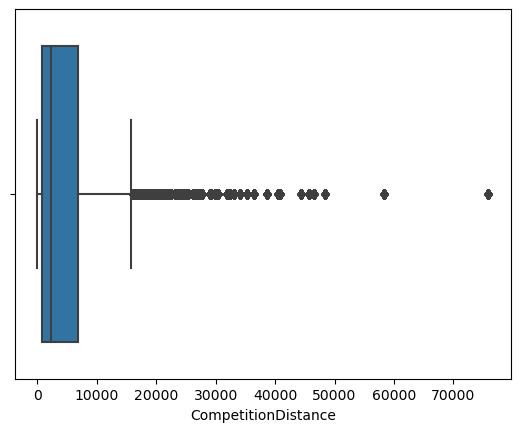

In [47]:
# Visualizing the boxlpot of 'Competition distance' column to check if we have outliers
sns.boxplot(x=df2_tv['CompetitionDistance'])
plt.show()

In [48]:
# Imputing the missing values using 'median' because of the presence of outliers
df2_tv['CompetitionDistance'].fillna(df2_tv['CompetitionDistance'].median(),inplace = True)

In [49]:
df2_tv.isnull().sum()

Store                  0
DayOfWeek              0
Sales                  0
Customers              0
Open                   0
Promo                  0
StateHoliday           0
SchoolHoliday          0
StoreType              0
Assortment             0
CompetitionDistance    0
Promo2                 0
Year                   0
Month                  0
Day                    0
dtype: int64

### Checking for the presence of outliers

In [50]:
cols_for_outlier = ['Store', 'DayOfWeek', 'Sales', 'Customers', 'CompetitionDistance']

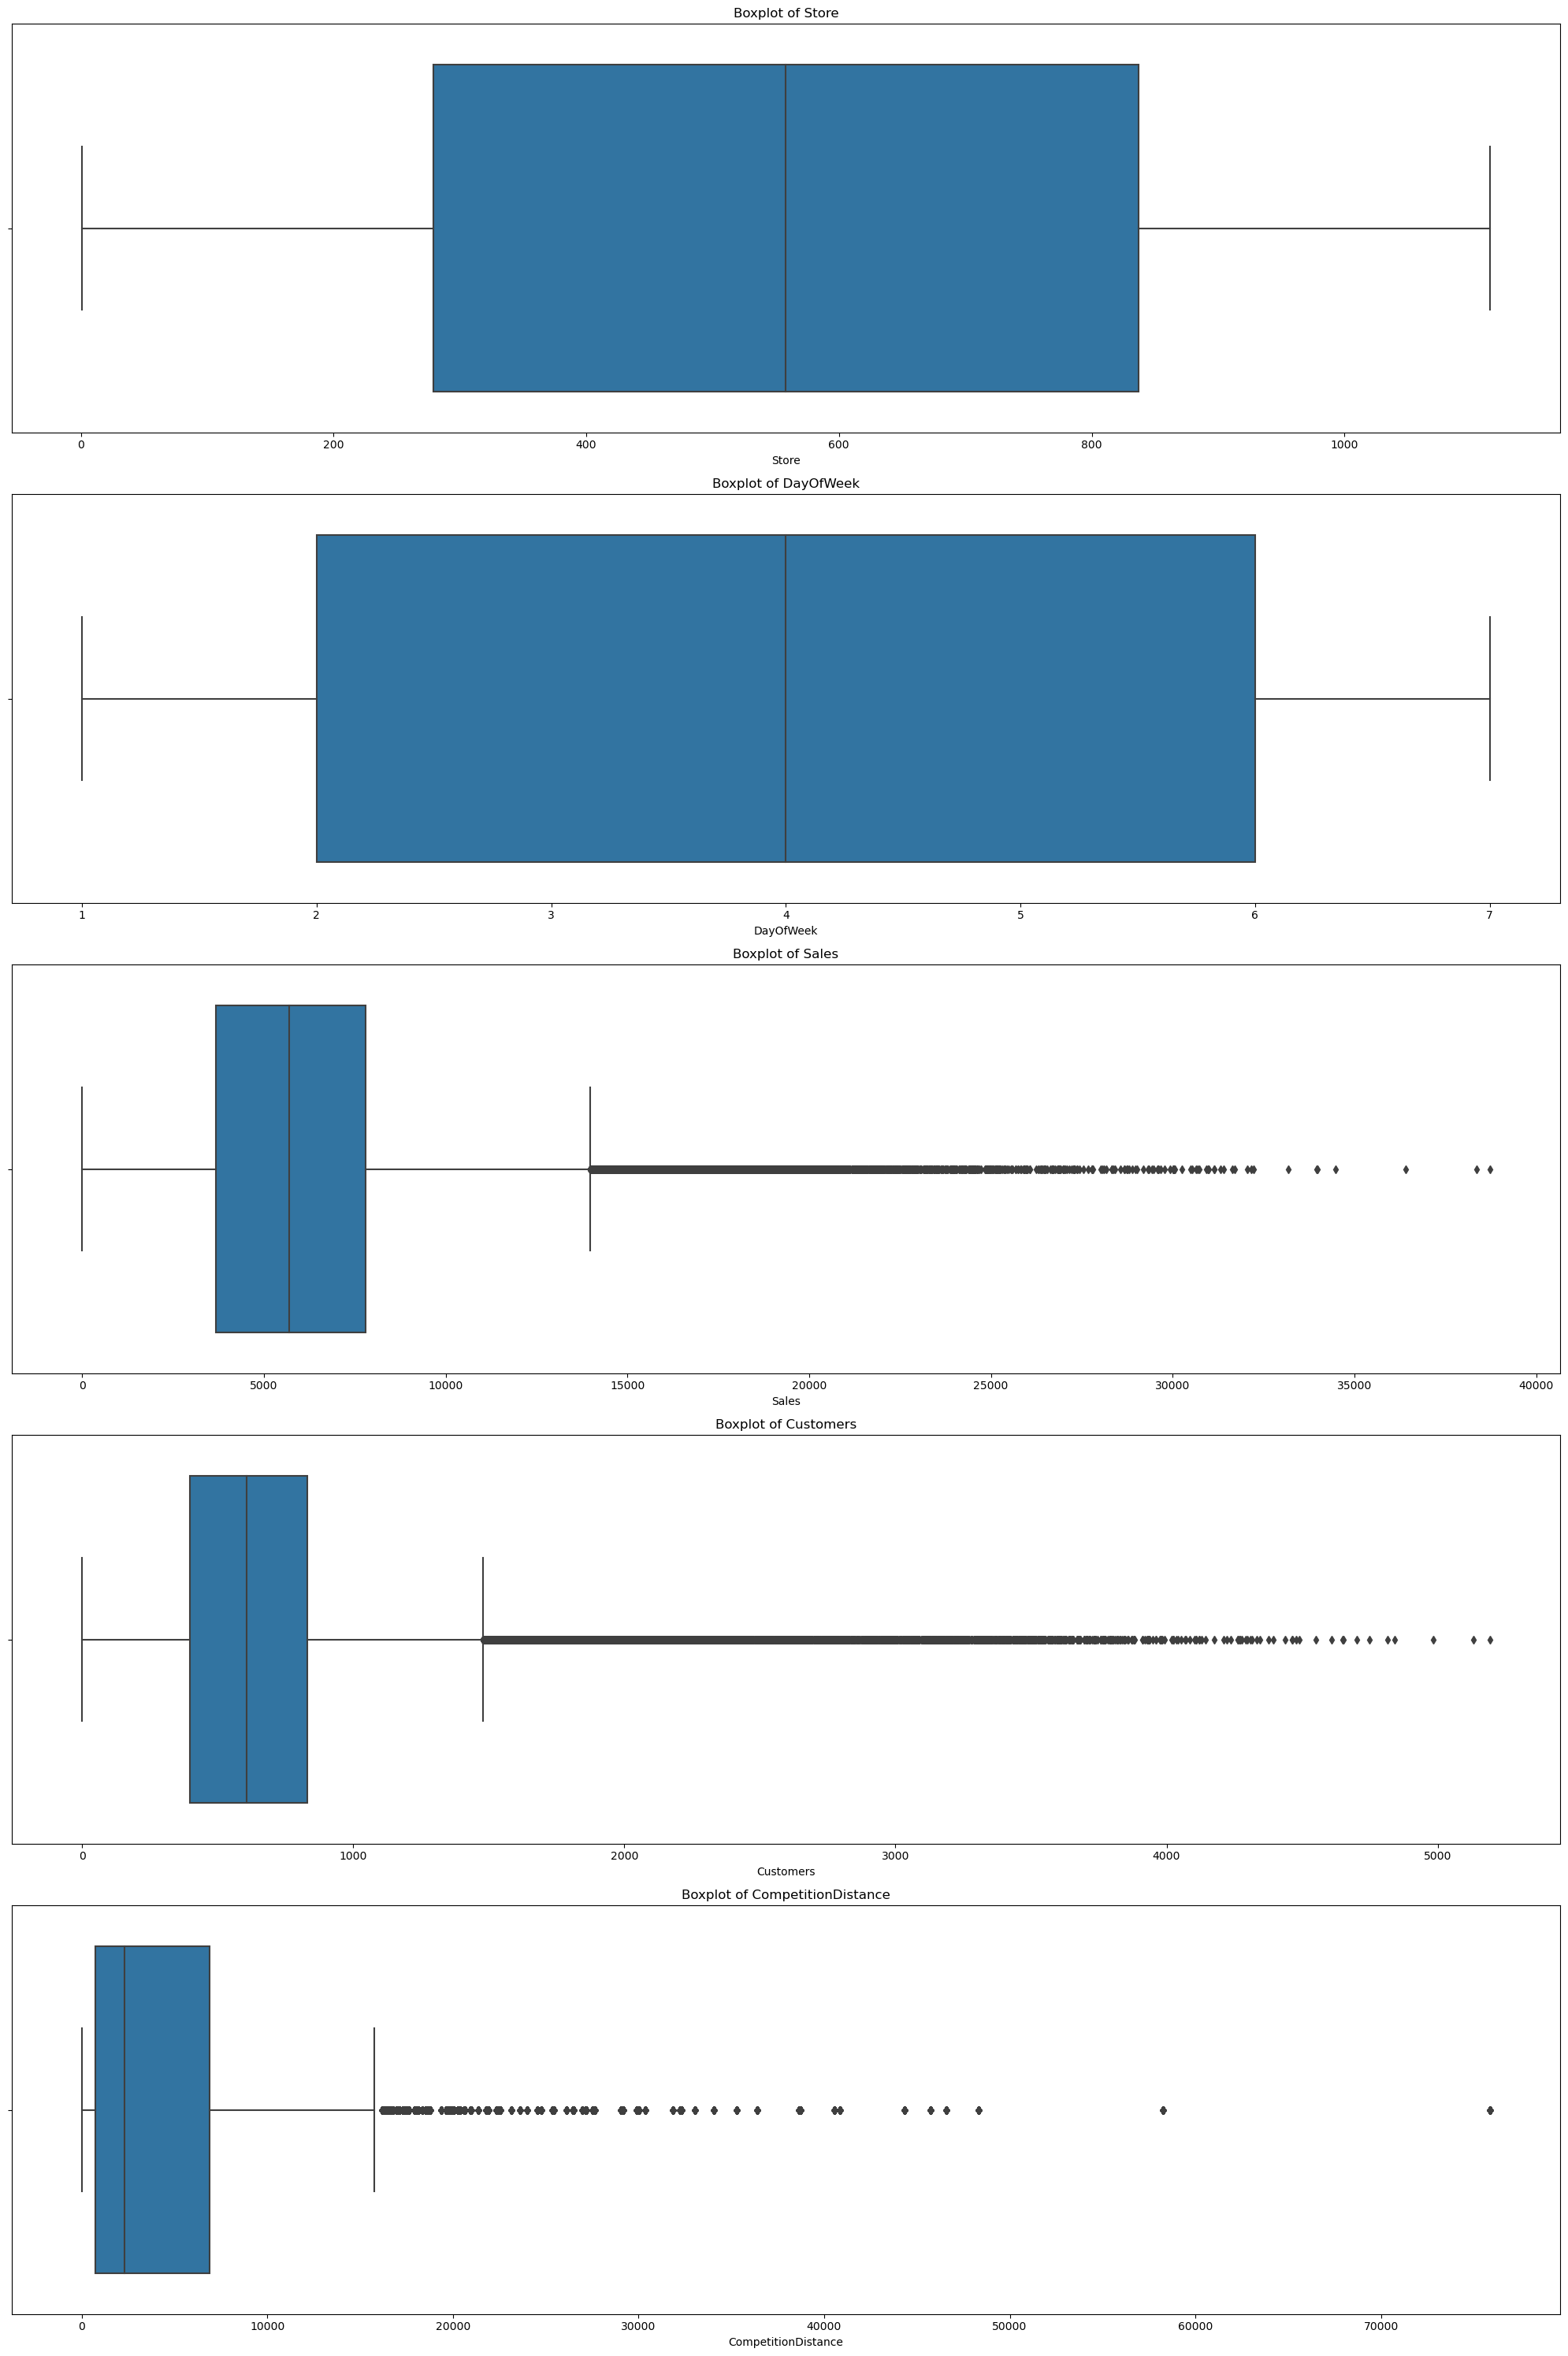

In [51]:
plt.figure(figsize=(20, 30))
for i, col in enumerate(cols_for_outlier, 1):
    plt.subplot(len(cols_for_outlier), 1, i)
    sns.boxplot(x=df2_tv[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.show()

### Encoding

In [52]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [53]:
df2_tv['StateHoliday'].value_counts()

0    165684
0     27463
a      4191
b      1417
c       830
Name: StateHoliday, dtype: int64

In [57]:
df2_tv['StateHoliday'] = df2_tv['StateHoliday'].replace(0,'0')

df2_tv['StateHoliday'] = df2_tv['StateHoliday'].replace(['0','a','b','c'],[0,1,1,1])

In [55]:
df2_tv['StateHoliday'].value_counts()

0    193147
a      4191
b      1417
c       830
Name: StateHoliday, dtype: int64

In [58]:
df2_tv['StateHoliday'].value_counts()

0    193147
1      6438
Name: StateHoliday, dtype: int64

In [59]:
df_tv_eda = df2_tv.copy()
df_tv_model = df2_tv.copy()

In [60]:
df2_tv['dateInt']=df2_tv['Year'].astype(str) + df2_tv['Month'].astype(str).str.zfill(2)+ df2_tv['Day'].astype(str).str.zfill(2)
df2_tv['Date'] = pd.to_datetime(df2_tv['dateInt'], format='%Y%m%d')

In [61]:
df_tv_eda['Date'] = df2_tv['Date']

In [62]:
df_tv_eda

Store  DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  \
Store                                                                          
1     483          1          5   4738        552     1      1             0   
      767          1          1   3549        494     1      0             0   
      378          1          5   4609        506     1      1             0   
      665          1          5   5447        619     1      0             0   
      638          1          4   4035        514     1      0             0   
...              ...        ...    ...        ...   ...    ...           ...   
1115  1016769   1115          7      0          0     0      0             0   
      1017016   1115          5   4714        344     1      0             0   
      1016954   1115          4   6110        394     1      1             0   
      1017030   1115          5   5651        378     1      0             0   
      1016542   1115          3   4906        356     1      0             0   

               SchoolHoliday StoreType Assortment  CompetitionDistance  \
Store                                                                    
1     483                  0         c          a               1270.0   
      767                  0         c          a               1270.0   
      378                  0         c          a               1270.0   
      665                  0         c          a               1270.0   
      638                  0         c          a               1270.0   
...                      ...       ...        ...                  ...   
1115  1016769              0         d          c               5350.0   
      1017016              1         d          c               5350.0   
      1016954              0         d          c               5350.0   
      1017030              0         d          c               5350.0   
      1016542              1         d          c               5350.0   

               Promo2  Year  Month  Day       Date  
Store                                               
1     483           0  2014      4    4 2014-04-04  
      767           0  2013      6   24 2013-06-24  
      378           0  2014      7   18 2014-07-18  
      665           0  2013     10    4 2013-10-04  
      638           0  2013     10   31 2013-10-31  
...               ...   ...    ...  ...        ...  
1115  1016769       1  2014      3   16 2014-03-16  
      1017016       1  2013      7   12 2013-07-12  
      1016954       1  2013      9   12 2013-09-12  
      1017030       1  2013      6   28 2013-06-28  
      1016542       1  2014     10   29 2014-10-29  

[199585 rows x 16 columns]

In [64]:
df_tv_model = pd.get_dummies(df_tv_model, columns=['StoreType', 'Assortment'])

In [65]:
df_tv_model

Store  DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  \
Store                                                                          
1     483          1          5   4738        552     1      1             0   
      767          1          1   3549        494     1      0             0   
      378          1          5   4609        506     1      1             0   
      665          1          5   5447        619     1      0             0   
      638          1          4   4035        514     1      0             0   
...              ...        ...    ...        ...   ...    ...           ...   
1115  1016769   1115          7      0          0     0      0             0   
      1017016   1115          5   4714        344     1      0             0   
      1016954   1115          4   6110        394     1      1             0   
      1017030   1115          5   5651        378     1      0             0   
      1016542   1115          3   4906        356     1      0             0   

               SchoolHoliday  CompetitionDistance  Promo2  Year  Month  Day  \
Store                                                                         
1     483                  0               1270.0       0  2014      4    4   
      767                  0               1270.0       0  2013      6   24   
      378                  0               1270.0       0  2014      7   18   
      665                  0               1270.0       0  2013     10    4   
      638                  0               1270.0       0  2013     10   31   
...                      ...                  ...     ...   ...    ...  ...   
1115  1016769              0               5350.0       1  2014      3   16   
      1017016              1               5350.0       1  2013      7   12   
      1016954              0               5350.0       1  2013      9   12   
      1017030              0               5350.0       1  2013      6   28   
      1016542              1               5350.0       1  2014     10   29   

               StoreType_a  StoreType_b  StoreType_c  StoreType_d  \
Store                                                               
1     483                0            0            1            0   
      767                0            0            1            0   
      378                0            0            1            0   
      665                0            0            1            0   
      638                0            0            1            0   
...                    ...          ...          ...          ...   
1115  1016769            0            0            0            1   
      1017016            0            0            0            1   
      1016954            0            0            0            1   
      1017030            0            0            0            1   
      1016542            0            0            0            1   

               Assortment_a  Assortment_b  Assortment_c  
Store                                                    
1     483                 1             0             0  
      767                 1             0             0  
      378                 1             0             0  
      665                 1             0             0  
      638                 1             0             0  
...                     ...           ...           ...  
1115  1016769             0             0             1  
      1017016             0             0             1  
      1016954             0             0             1  
      1017030             0             0             1  
      1016542             0             0             1  

[199585 rows x 20 columns]

### Feature scaling

In [66]:
from sklearn.preprocessing import StandardScaler

In [67]:
ss_cols = ['Customers','CompetitionDistance']
ss = StandardScaler()
df_tv_model[ss_cols] = ss.fit_transform(df_tv_model[ss_cols])

In [68]:
df_tv_model

Store  DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  \
Store                                                                          
1     483          1          5   4738  -0.164055     1      1             0   
      767          1          1   3549  -0.289752     1      0             0   
      378          1          5   4609  -0.263745     1      1             0   
      665          1          5   5447  -0.018854     1      0             0   
      638          1          4   4035  -0.246408     1      0             0   
...              ...        ...    ...        ...   ...    ...           ...   
1115  1016769   1115          7      0  -1.360341     0      0             0   
      1017016   1115          5   4714  -0.614830     1      0             0   
      1016954   1115          4   6110  -0.506470     1      1             0   
      1017030   1115          5   5651  -0.541145     1      0             0   
      1016542   1115          3   4906  -0.588823     1      0             0   

               SchoolHoliday  CompetitionDistance  Promo2  Year  Month  Day  \
Store                                                                         
1     483                  0            -0.539351       0  2014      4    4   
      767                  0            -0.539351       0  2013      6   24   
      378                  0            -0.539351       0  2014      7   18   
      665                  0            -0.539351       0  2013     10    4   
      638                  0            -0.539351       0  2013     10   31   
...                      ...                  ...     ...   ...    ...  ...   
1115  1016769              0            -0.006093       1  2014      3   16   
      1017016              1            -0.006093       1  2013      7   12   
      1016954              0            -0.006093       1  2013      9   12   
      1017030              0            -0.006093       1  2013      6   28   
      1016542              1            -0.006093       1  2014     10   29   

               StoreType_a  StoreType_b  StoreType_c  StoreType_d  \
Store                                                               
1     483                0            0            1            0   
      767                0            0            1            0   
      378                0            0            1            0   
      665                0            0            1            0   
      638                0            0            1            0   
...                    ...          ...          ...          ...   
1115  1016769            0            0            0            1   
      1017016            0            0            0            1   
      1016954            0            0            0            1   
      1017030            0            0            0            1   
      1016542            0            0            0            1   

               Assortment_a  Assortment_b  Assortment_c  
Store                                                    
1     483                 1             0             0  
      767                 1             0             0  
      378                 1             0             0  
      665                 1             0             0  
      638                 1             0             0  
...                     ...           ...           ...  
1115  1016769             0             0             1  
      1017016             0             0             1  
      1016954             0             0             1  
      1017030             0             0             1  
      1016542             0             0             1  

[199585 rows x 20 columns]

## EDA

### Univariate

#### 'Sales' distribution

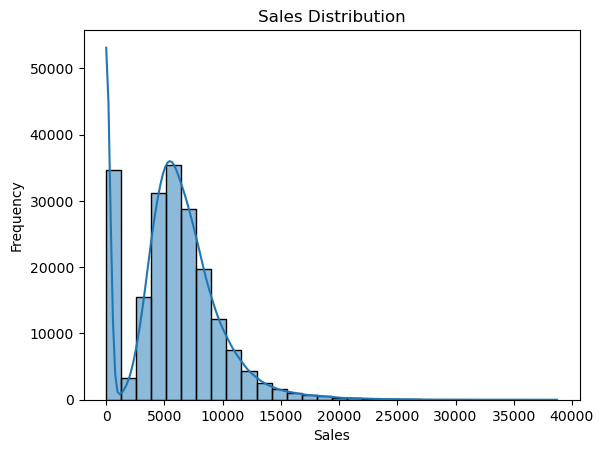

In [69]:
sns.histplot(df_tv_eda['Sales'], bins=30, kde=True)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

#### Observations:

Most of the values of Sales are normally distributed and the distribution is slightly skewed on the right.

#### 'Store type' distribution

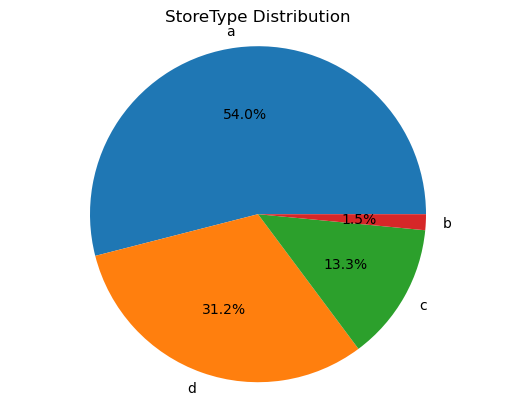

In [74]:
store_type_counts = df_tv_eda['StoreType'].value_counts()
plt.pie(store_type_counts, labels=store_type_counts.index, autopct='%1.1f%%', startangle=0)
plt.title('StoreType Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

The Storetype 'a' 

#### Observations:

Most stores belong to StoreType 'a', followed by 'd', 'c', and 'b', indicating a diverse store type distribution with a dominance of type 'a'.

#### 'Assortment' distribution

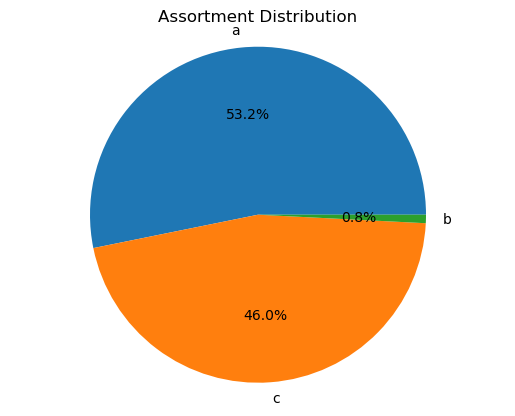

In [75]:
assortment_counts = df_tv_eda['Assortment'].value_counts()
plt.pie(assortment_counts, labels=assortment_counts.index, autopct='%1.1f%%')
plt.title('Assortment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

#### Observations:

Assortment type 'a' is the most common, highlighting a preference for a particular assortment category in the stores.

#### 'Sales' vs 'Time'

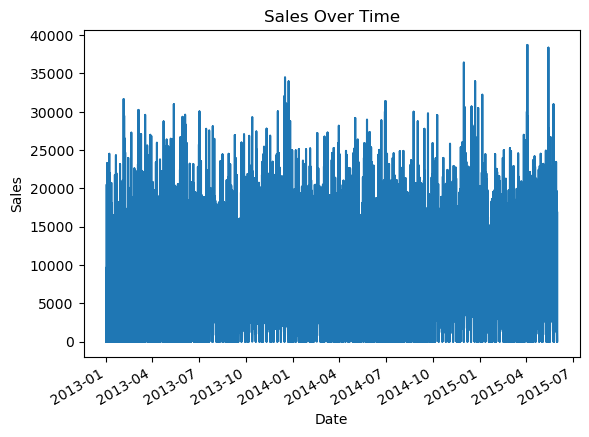

In [76]:
df_tv_eda.set_index('Date')['Sales'].plot()
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

#### Observations:

There are noticeable peaks and troughs in sales over time, indicating seasonal and promotional impacts on sales.

#### Heatmap for 'Store type' and 'Assortment'

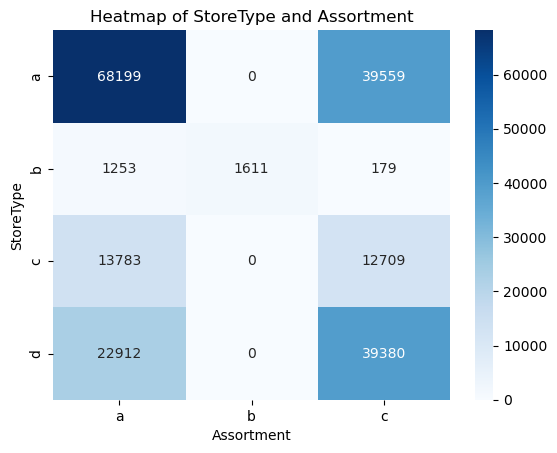

In [77]:
pivot_table = df_tv_eda.pivot_table(index='StoreType', columns='Assortment', aggfunc='size', fill_value=0)

sns.heatmap(pivot_table, annot=True, fmt='d', cmap='Blues')
plt.title('Heatmap of StoreType and Assortment')
plt.xlabel('Assortment')
plt.ylabel('StoreType')
plt.show()

#### Observations:

There is a strong presence of Assortment 'a' across all store types, especially in StoreType 'a', suggesting a potential strategic assortment placement.

#### 'Day Of Week' vs 'Customers'

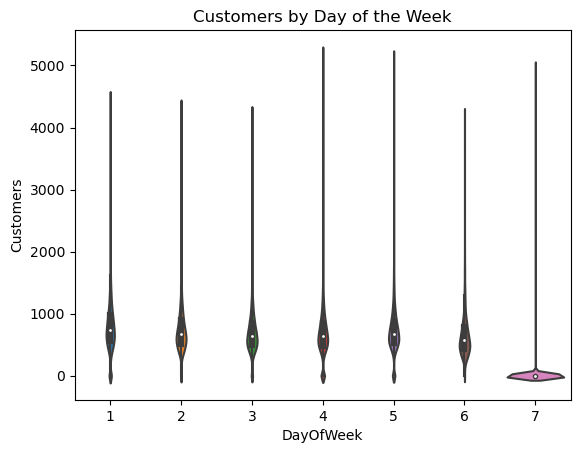

In [78]:
sns.violinplot(x='DayOfWeek', y='Customers', data=df_tv_eda)
plt.title('Customers by Day of the Week')
plt.xlabel('DayOfWeek')
plt.ylabel('Customers')
plt.show()

#### Observations:

Customer count peaks on Fridays and Saturdays, suggesting higher footfall during weekends.

#### 'Competition distance' vs 'Sales'

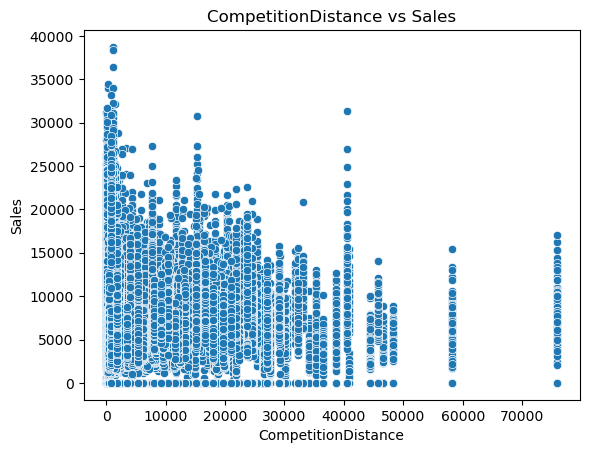

In [89]:
sns.scatterplot(x='CompetitionDistance', y='Sales', data=df_tv_eda)
plt.title('CompetitionDistance vs Sales')
plt.xlabel('CompetitionDistance')
plt.ylabel('Sales')
plt.show()

#### Observations:

The stores are not that far from eachother and the stores that are nearby observed more sales

#### 'Store type' vs 'Sales' divided by 'Assortment'

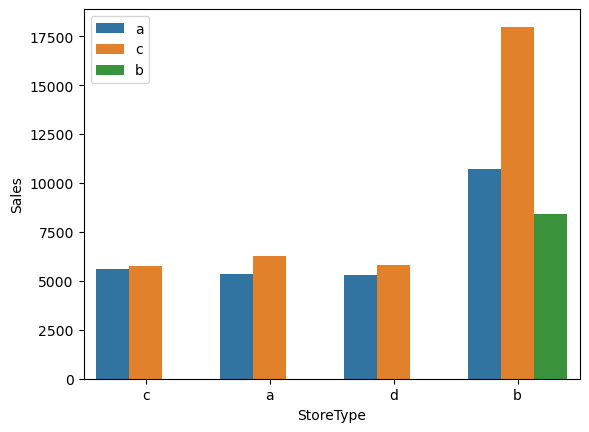

In [83]:
sns.barplot(x=df_tv_eda["StoreType"],y=df_tv_eda['Sales'],hue=df_tv_eda["Assortment"], ci=None)
plt.legend(loc='best')
plt.show()

#### Observations:

StoreType 'b' consistently achieves the highest sales across all assortment types, highlighting its effectiveness regardless of product variety. Assortment 'a' drives higher sales across all store types, emphasizing its popularity and potential as a key product category for boosting sales.

#### 'Monthly sales' over 'Years'

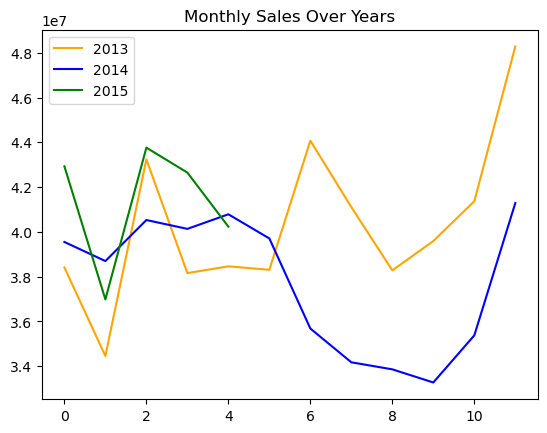

In [86]:
sales_df_tv_eda_2013 = df_tv_eda[df_tv_eda['Year']== 2013]
sales_df_tv_eda_2014 = df_tv_eda[df_tv_eda['Year']==2014]
sales_df_tv_eda_2015 = df_tv_eda[df_tv_eda['Year']== 2015]
     
sales_2013 = sales_df_tv_eda_2013.groupby('Month')['Sales'].sum().reset_index()
sales_2014 = sales_df_tv_eda_2014.groupby('Month')['Sales'].sum().reset_index()
sales_2015 = sales_df_tv_eda_2015.groupby('Month')['Sales'].sum().reset_index()

plt.plot(sales_2013.loc[:,'Sales'],label='2013',color='orange')
plt.plot(sales_2014.loc[:,'Sales'],label='2014',color='blue')
plt.plot(sales_2015.loc[:,'Sales'],label='2015',color='green')
plt.title('Monthly Sales Over Years')
plt.legend()
plt.show()

#### Observations:

Sales exhibit a similar seasonal pattern each year, with noticeable peaks around mid-year and end-of-year, indicating consistent seasonal trends. Yearly Sales Growth: There is a clear upward trend in sales from 2013 to 2015, reflecting overall growth in sales performance across the years.

#### 'Independent variables' vs 'Sales'

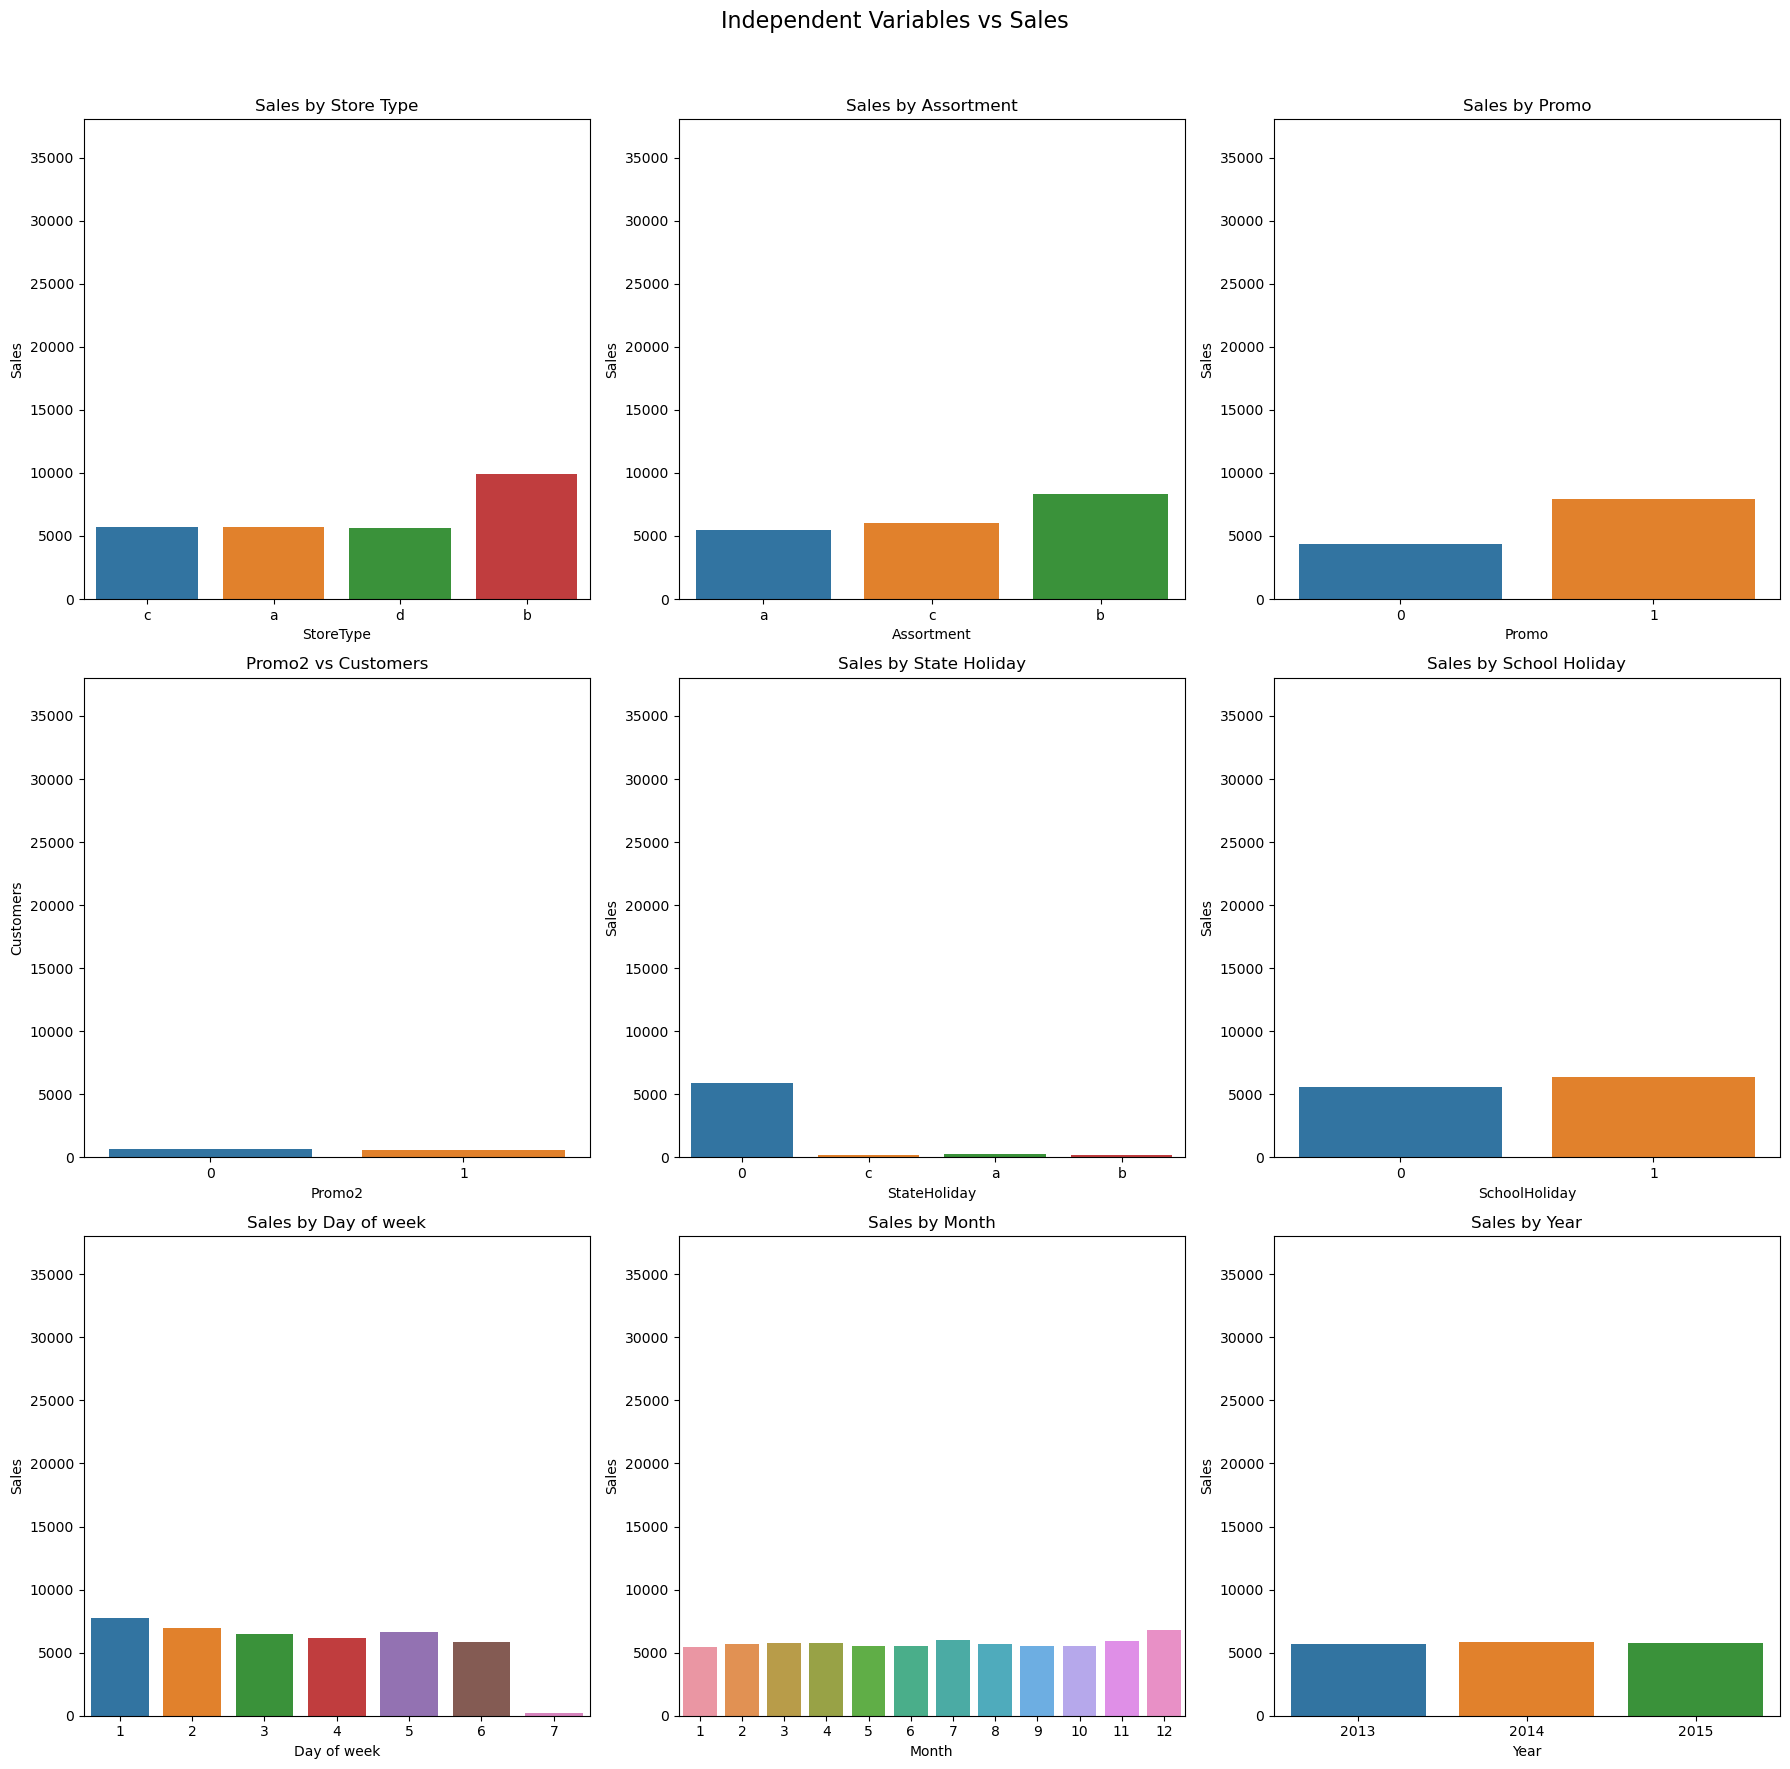

In [67]:
y_min = df_tv_eda['Sales'].min()
y_max = df_tv_eda['Sales'].max()

fig, axes = plt.subplots(3, 3, figsize=(18,18))
fig.suptitle('Independent Variables vs Sales', fontsize=16)

# Sales by Store Type
sns.barplot(x='StoreType', y='Sales', data=df_tv_eda, ax=axes[0, 0], ci=None)
axes[0, 0].set_title('Sales by Store Type')
axes[0, 0].set_xlabel('StoreType')
axes[0, 0].set_ylabel('Sales')
axes[0, 0].set_ylim(y_min, y_max)

# Sales by Assortment
sns.barplot(x='Assortment', y='Sales', data=df_tv_eda, ax=axes[0, 1], ci=None)
axes[0, 1].set_title('Sales by Assortment')
axes[0, 1].set_xlabel('Assortment')
axes[0, 1].set_ylabel('Sales')
axes[0, 1].set_ylim(y_min, y_max)

# Sales by Promo
sns.barplot(x='Promo', y='Sales', data=df_tv_eda, ax=axes[0,2], ci=None)
axes[0,2].set_title('Sales by Promo')
axes[0,2].set_xlabel('Promo')
axes[0,2].set_ylabel('Sales')
axes[0,2].set_ylim(y_min, y_max)

# Sales by Promo2
sns.barplot(x='Promo2', y='Customers', data=df_tv_eda, ax=axes[1, 0], ci=None)
axes[1, 0].set_title('Promo2 vs Customers')
axes[1, 0].set_xlabel('Promo2')
axes[1, 0].set_ylabel('Customers')
axes[1, 0].set_ylim(y_min, y_max)

# Sales by State Holiday
sns.barplot(x='StateHoliday', y='Sales', data=df_tv_eda, ax=axes[1,1], ci=None)
axes[1,1].set_title('Sales by State Holiday')
axes[1,1].set_xlabel('StateHoliday')
axes[1,1].set_ylabel('Sales')
axes[1,1].set_ylim(y_min, y_max)

# Sales by School Holiday
sns.barplot(x='SchoolHoliday', y='Sales', data=df_tv_eda, ax=axes[1,2], ci=None)
axes[1,2].set_title('Sales by School Holiday')
axes[1,2].set_xlabel('SchoolHoliday')
axes[1,2].set_ylabel('Sales')
axes[1,2].set_ylim(y_min, y_max)

# Sales by Day of week
sns.barplot(x='DayOfWeek', y='Sales', data=df_tv_eda, ax=axes[2,0], ci=None)
axes[2,0].set_title('Sales by Day of week')
axes[2,0].set_xlabel('Day of week')
axes[2,0].set_ylabel('Sales')
axes[2,0].set_ylim(y_min, y_max)

# Sales by Month
sns.barplot(x='Month', y='Sales', data=df_tv_eda, ax=axes[2,1], ci=None)
axes[2,1].set_title('Sales by Month')
axes[2,1].set_xlabel('Month')
axes[2,1].set_ylabel('Sales')
axes[2,1].set_ylim(y_min, y_max)

# Sales by Year
sns.barplot(x='Year', y='Sales', data=df_tv_eda, ax=axes[2,2], ci=None)
axes[2,2].set_title('Sales by Year')
axes[2,2].set_xlabel('Year')
axes[2,2].set_ylabel('Sales')
axes[2,2].set_ylim(y_min, y_max)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Observations:

**Sales by Store Type:** StoreType 'b' shows the highest sales on average, indicating that this type of store might be more effective in driving sales.

**Sales by Assortment:** Assortment 'a' drives the highest sales, reflecting its popularity among customers.

**Sales by Promo:** Sales are significantly higher during promotional periods, demonstrating the effectiveness of promotions.

**Sales by Promo2:** The consistent increase in customer numbers during Promo2 periods underscores the importance of ongoing promotional activities to boost customer engagement and sales.

**Sales by State Holiday:** Sales tend to increase during state holidays, indicating holiday periods as high sales opportunities.

**Sales by School Holiday:** Sales show an increase during school holidays, possibly due to increased family shopping.

**Sales by Day of Week:** Sales are higher towards the end of the week, especially on Fridays and Saturdays.

**Sales by Month:** Sales fluctuate throughout the year with noticeable peaks during certain months, indicating seasonality.

**Sales by Year:** Sales have been increasing year over year, suggesting overall growth in store performance.

#### 'Independent variables' vs 'Customers'

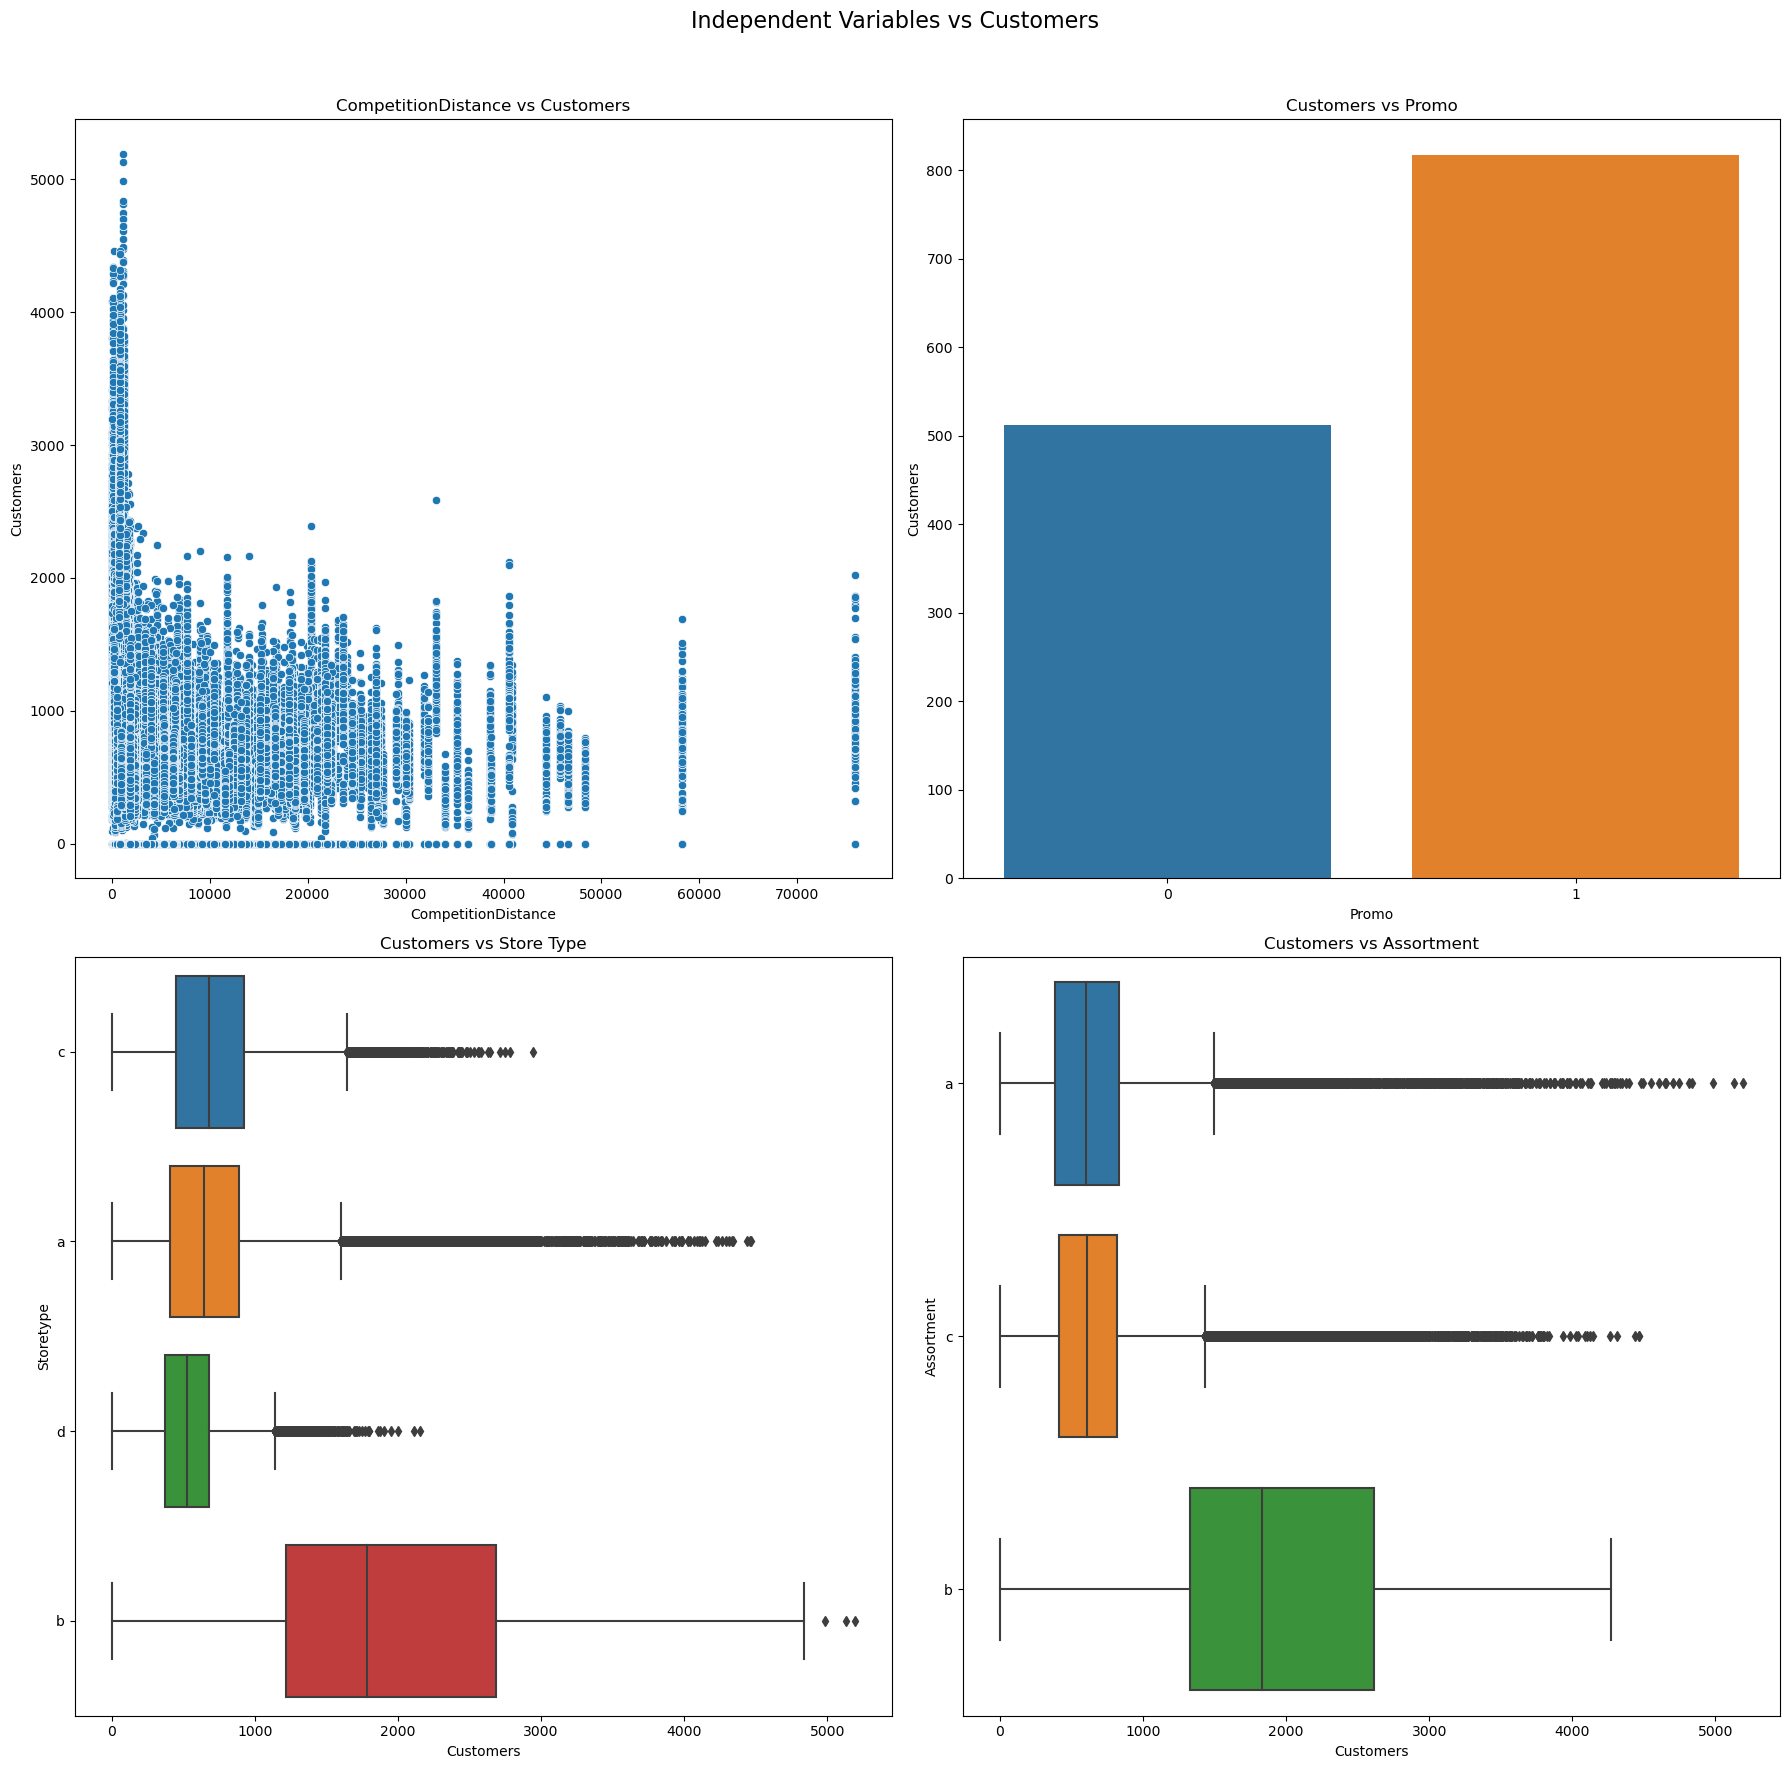

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(18,18))
fig.suptitle('Independent Variables vs Customers', fontsize=16)

# Customers vs CompetitionDistance
sns.scatterplot(x='CompetitionDistance', y='Customers', data=df_tv_eda, ax=axes[0, 0])
axes[0, 0].set_title('CompetitionDistance vs Customers')
axes[0, 0].set_xlabel('CompetitionDistance')
axes[0, 0].set_ylabel('Customers')
# axes[0, 0].set_ylim(y_min, y_max)

# Customers vs Promo
sns.barplot(x='Promo', y='Customers', data=df_tv_eda, ax=axes[0, 1], ci=None)
axes[0, 1].set_title('Customers vs Promo')
axes[0, 1].set_xlabel('Promo')
axes[0, 1].set_ylabel('Customers')
# axes[0, 0].set_ylim(y_min, y_max)

# Customers vs Storetype
sns.boxplot(x='Customers', y='StoreType', data=df_tv_eda, ax=axes[1, 0])
axes[1, 0].set_title('Customers vs Store Type')
axes[1, 0].set_xlabel('Customers')
axes[1, 0].set_ylabel('Storetype')
# axes[0, 0].set_ylim(y_min, y_max)

# Customers vs Assortment
sns.boxplot(x='Customers', y='Assortment', data=df_tv_eda, ax=axes[1, 1])
axes[1, 1].set_title('Customers vs Assortment')
axes[1, 1].set_xlabel('Customers')
axes[1, 1].set_ylabel('Assortment')
# axes[0, 0].set_ylim(y_min, y_max)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Observations:

**Customers by CompetitionDistance:** No clear pattern, indicating competition distance might not directly impact customer count.

**Customers by Promo:** Customer count increases during promotional periods, aligning with higher sales during promotions.

**Customers by Store Type:** StoreType 'b' attracts the highest number of customers, similar to its high sales performance.

**Customers by Assortment:** Assortment 'a' is associated with higher customer counts, similar to its impact on sales.

#### Correlation

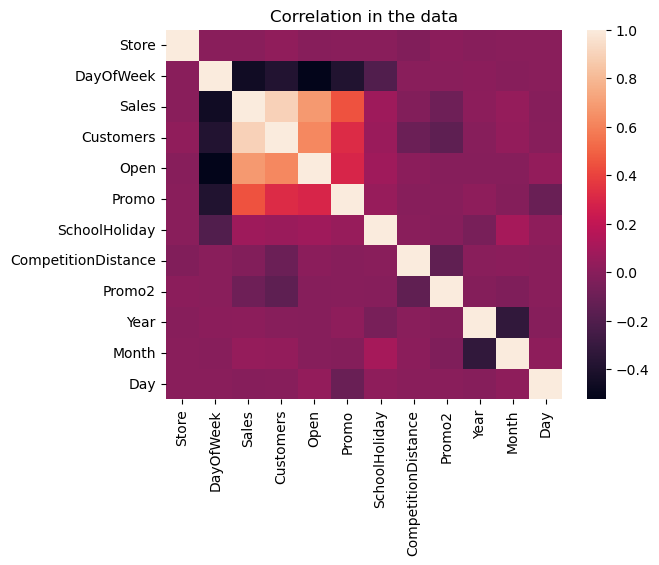

In [69]:
plt.title('Correlation in the data', loc='center')
sns.heatmap(df_tv_eda.corr(), fmt='.2f')
plt.show()

#### Observations:

Sales are moderately correlated with customers, promo, and day of the week, indicating these features impact sales.

#### Pair plot

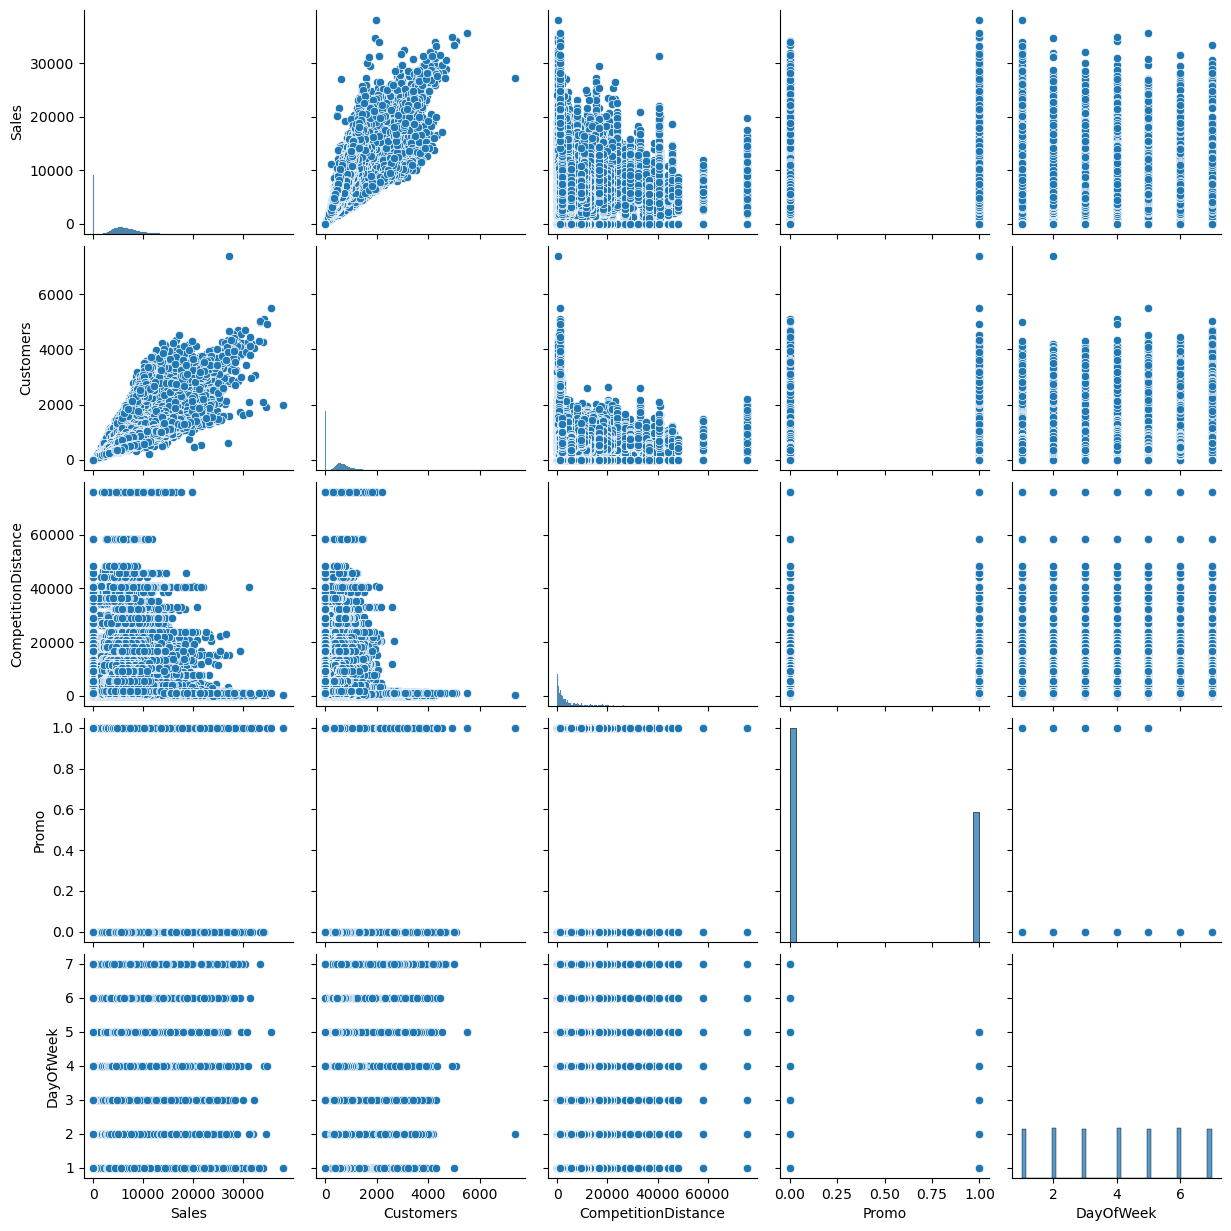

In [70]:
sns.pairplot(df_tv_eda[['Sales', 'Customers', 'CompetitionDistance', 'Promo', 'DayOfWeek']])
plt.show()

#### Observations:

Positive relationships are observed between sales and customers, while other features show varied levels of interaction.

## Training and validation split

In [90]:
df_tv_model

Store  DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  \
Store                                                                          
1     483          1          5   4738  -0.164055     1      1             0   
      767          1          1   3549  -0.289752     1      0             0   
      378          1          5   4609  -0.263745     1      1             0   
      665          1          5   5447  -0.018854     1      0             0   
      638          1          4   4035  -0.246408     1      0             0   
...              ...        ...    ...        ...   ...    ...           ...   
1115  1016769   1115          7      0  -1.360341     0      0             0   
      1017016   1115          5   4714  -0.614830     1      0             0   
      1016954   1115          4   6110  -0.506470     1      1             0   
      1017030   1115          5   5651  -0.541145     1      0             0   
      1016542   1115          3   4906  -0.588823     1      0             0   

               SchoolHoliday  CompetitionDistance  Promo2  Year  Month  Day  \
Store                                                                         
1     483                  0            -0.539351       0  2014      4    4   
      767                  0            -0.539351       0  2013      6   24   
      378                  0            -0.539351       0  2014      7   18   
      665                  0            -0.539351       0  2013     10    4   
      638                  0            -0.539351       0  2013     10   31   
...                      ...                  ...     ...   ...    ...  ...   
1115  1016769              0            -0.006093       1  2014      3   16   
      1017016              1            -0.006093       1  2013      7   12   
      1016954              0            -0.006093       1  2013      9   12   
      1017030              0            -0.006093       1  2013      6   28   
      1016542              1            -0.006093       1  2014     10   29   

               StoreType_a  StoreType_b  StoreType_c  StoreType_d  \
Store                                                               
1     483                0            0            1            0   
      767                0            0            1            0   
      378                0            0            1            0   
      665                0            0            1            0   
      638                0            0            1            0   
...                    ...          ...          ...          ...   
1115  1016769            0            0            0            1   
      1017016            0            0            0            1   
      1016954            0            0            0            1   
      1017030            0            0            0            1   
      1016542            0            0            0            1   

               Assortment_a  Assortment_b  Assortment_c  
Store                                                    
1     483                 1             0             0  
      767                 1             0             0  
      378                 1             0             0  
      665                 1             0             0  
      638                 1             0             0  
...                     ...           ...           ...  
1115  1016769             0             0             1  
      1017016             0             0             1  
      1016954             0             0             1  
      1017030             0             0             1  
      1016542             0             0             1  

[199585 rows x 20 columns]

In [91]:
x = df_tv_model[['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'CompetitionDistance', 'Promo2', 'Year', 'Month',
       'Day', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c']]

In [92]:
x

Store  DayOfWeek  Customers  Open  Promo  StateHoliday  \
Store                                                                   
1     483          1          5  -0.164055     1      1             0   
      767          1          1  -0.289752     1      0             0   
      378          1          5  -0.263745     1      1             0   
      665          1          5  -0.018854     1      0             0   
      638          1          4  -0.246408     1      0             0   
...              ...        ...        ...   ...    ...           ...   
1115  1016769   1115          7  -1.360341     0      0             0   
      1017016   1115          5  -0.614830     1      0             0   
      1016954   1115          4  -0.506470     1      1             0   
      1017030   1115          5  -0.541145     1      0             0   
      1016542   1115          3  -0.588823     1      0             0   

               SchoolHoliday  CompetitionDistance  Promo2  Year  Month  Day  \
Store                                                                         
1     483                  0            -0.539351       0  2014      4    4   
      767                  0            -0.539351       0  2013      6   24   
      378                  0            -0.539351       0  2014      7   18   
      665                  0            -0.539351       0  2013     10    4   
      638                  0            -0.539351       0  2013     10   31   
...                      ...                  ...     ...   ...    ...  ...   
1115  1016769              0            -0.006093       1  2014      3   16   
      1017016              1            -0.006093       1  2013      7   12   
      1016954              0            -0.006093       1  2013      9   12   
      1017030              0            -0.006093       1  2013      6   28   
      1016542              1            -0.006093       1  2014     10   29   

               StoreType_a  StoreType_b  StoreType_c  StoreType_d  \
Store                                                               
1     483                0            0            1            0   
      767                0            0            1            0   
      378                0            0            1            0   
      665                0            0            1            0   
      638                0            0            1            0   
...                    ...          ...          ...          ...   
1115  1016769            0            0            0            1   
      1017016            0            0            0            1   
      1016954            0            0            0            1   
      1017030            0            0            0            1   
      1016542            0            0            0            1   

               Assortment_a  Assortment_b  Assortment_c  
Store                                                    
1     483                 1             0             0  
      767                 1             0             0  
      378                 1             0             0  
      665                 1             0             0  
      638                 1             0             0  
...                     ...           ...           ...  
1115  1016769             0             0             1  
      1017016             0             0             1  
      1016954             0             0             1  
      1017030             0             0             1  
      1016542             0             0             1  

[199585 rows x 19 columns]

In [93]:
y = df_tv_model[['Sales']]

In [94]:
y

Sales
Store               
1     483       4738
      767       3549
      378       4609
      665       5447
      638       4035
...              ...
1115  1016769      0
      1017016   4714
      1016954   6110
      1017030   5651
      1016542   4906

[199585 rows x 1 columns]

In [95]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [96]:
x_train

,,Store,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,Promo2,Year,Month,Day,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
Store,,,,,,,,,,,,,,,,,,,,
149,134949,149,6,-0.482631,1,0,0,0,-0.364212,1,2013,9,14,0,0,0,1,1,0,0
549,499802,549,6,-0.484798,1,0,0,0,-0.400808,0,2015,3,7,1,0,0,0,0,0,1
1024,934023,1024,6,0.525110,1,0,0,0,-0.445246,0,2013,2,9,0,0,1,0,0,0,1
410,373565,410,5,0.494769,1,0,0,0,-0.700112,1,2015,5,29,0,0,1,0,1,0,0
272,246847,272,2,0.236874,1,0,0,1,1.409394,1,2014,12,30,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,610327,670,3,-0.044860,1,0,0,0,-0.436097,1,2013,7,24,1,0,0,0,1,0,0
580,528425,580,3,2.360716,1,1,0,0,-0.683121,0,2014,10,1,1,0,0,0,0,0,1
738,672052,738,5,0.273717,1,0,0,0,0.076249,0,2013,5,24,0,0,0,1,0,0,1


In [97]:
x_test

,,Store,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,Promo2,Year,Month,Day,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
Store,,,,,,,,,,,,,,,,,,,,
161,145630,161,2,0.145853,1,0,0,0,-0.317160,0,2014,5,27,1,0,0,0,0,0,1
840,765346,840,2,-0.562817,1,0,0,1,-0.565491,0,2013,12,24,1,0,0,0,1,0,0
271,245845,271,6,-0.679845,1,0,0,0,-0.650446,1,2015,2,28,1,0,0,0,1,0,0
1082,987162,1082,3,0.971550,1,1,0,0,-0.647832,0,2013,3,6,0,0,1,0,1,0,0
218,197306,218,6,-0.430619,1,0,0,0,-0.621692,1,2013,5,18,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,159034,176,6,-0.543312,1,0,0,0,-0.212599,0,2014,5,17,1,0,0,0,1,0,0
530,483611,530,3,-0.688514,1,1,0,0,1.668181,0,2013,1,9,1,0,0,0,0,0,1
1049,956648,1049,6,0.004986,1,0,0,0,-0.656981,1,2013,8,17,1,0,0,0,1,0,0


In [98]:
y_train

,,Sales
Store,,
149,134949,4109
549,499802,3511
1024,934023,6131
410,373565,7273
272,246847,7337
...,...,...
670,610327,5345
580,528425,11253
738,672052,8081


In [99]:
y_test

,,Sales
Store,,
161,145630,5798
840,765346,2525
271,245845,3958
1082,987162,7080
218,197306,2873
...,...,...
176,159034,2750
530,483611,2282
1049,956648,3250


## Model building

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor

In [82]:
num=1
r2_scores_all_models=pd.DataFrame(columns=['Training_R2', 'Testing_R2'])

def model_building(model):
    global num
    print(f'Model-{num} : {model}\n')
    mdl=model.fit(x_train,y_train)
    mdl_pred_train=mdl.predict(x_train)
    mdl_pred_test=mdl.predict(x_test)
    
    train_mae=mean_absolute_error(y_train,mdl_pred_train)
    print("Train MAE : ",train_mae)
    test_mae=mean_absolute_error(y_test,mdl_pred_test)
    print("Test MAE : ",test_mae)
    print()

    train_mse=mean_squared_error(y_train,mdl_pred_train)
    print("Train MSE : ",train_mse)
    test_mse=mean_squared_error(y_test,mdl_pred_test)
    print("Test MSE : ",test_mse)
    print()
    
    train_rmse=np.sqrt(train_mse)
    print("Train RMSE : ",train_rmse)
    test_rmse=np.sqrt(test_mse)
    print("Test RMSE : ",test_rmse)
    print()
    
    train_r2=r2_score(y_train,mdl_pred_train)
    print("Train r2_score : ",train_r2)
    test_r2=r2_score(y_test,mdl_pred_test)
    print("Test r2_score : ",test_r2)
    print()
    num+=1
    
    res=pd.DataFrame({'Training r2_score':[train_r2],'Testing r2_score':[test_r2]})
    global r2_scores_all_models
    r2_scores_all_models=pd.concat([r2_scores_all_models,res],ignore_index=True)

In [83]:
model_building(LinearRegression())

Model-1 : LinearRegression()

Train MAE :  876.9348146158605
Test MAE :  872.1815351678819

Train MSE :  1481934.3000077468
Test MSE :  1473325.2267725326

Train RMSE :  1217.347238879584
Test RMSE :  1213.8060910922027

Train r2_score :  0.9000216534071478
Test r2_score :  0.8983467777054068



In [84]:
model_building(DecisionTreeRegressor())

Model-2 : DecisionTreeRegressor()

Train MAE :  0.0
Test MAE :  496.27031089510734

Train MSE :  0.0
Test MSE :  702494.9323846983

Train RMSE :  0.0
Test RMSE :  838.1497076207199

Train r2_score :  1.0
Test r2_score :  0.9515308146328563



In [85]:
model_building(RandomForestRegressor())

Model-3 : RandomForestRegressor()

Train MAE :  132.87325036951674
Test MAE :  355.71311746874767

Train MSE :  48861.746197630084
Test MSE :  350794.1589557557

Train RMSE :  221.0469321153996
Test RMSE :  592.278784826669

Train r2_score :  0.9967035538643966
Test r2_score :  0.9757966836025134



In [86]:
model_building(KNeighborsRegressor())

Model-4 : KNeighborsRegressor()

Train MAE :  1130.508204524388
Test MAE :  1436.7817972292507

Train MSE :  2417695.0379858203
Test MSE :  3810817.8891109047

Train RMSE :  1554.8938992695998
Test RMSE :  1952.13162699417

Train r2_score :  0.8368907768297813
Test r2_score :  0.7370696496831168



In [87]:
model_building(svm.SVR())

Model-5 : SVR()

Train MAE :  2886.2425459645383
Test MAE :  2867.4631446300587

Train MSE :  14822759.06893572
Test MSE :  14494365.397744069

Train RMSE :  3850.0336451693147
Test RMSE :  3807.14662151907

Train r2_score :  -1.3930205038370502e-05
Test r2_score :  -5.0037169028183115e-05



In [89]:
model_building(XGBRegressor())

Model-6 : XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Train MAE :  369.2514134663336
Test MAE :  383.65110082062745

Train MSE :  281858.1655225351
Test MSE :  320524.41716832726

Train RMSE :  530.9031602114787
Test RMSE :  566.1487588684861

Train r2_score :  0.980984505613717
Test r2_score : 

In [90]:
model_building(GradientBoostingRegressor())

Model-7 : GradientBoostingRegressor()

Train MAE :  661.4860049176543
Test MAE :  660.7824237519404

Train MSE :  907299.118464155
Test MSE :  911738.7676378335

Train RMSE :  952.5225028649743
Test RMSE :  954.8501283645688

Train r2_score :  0.938789279842754
Test r2_score :  0.9370938731400706



In [91]:
model_building(AdaBoostRegressor())

Model-8 : AdaBoostRegressor()

Train MAE :  1917.1272517866003
Test MAE :  1911.8787991532756

Train MSE :  5070621.226116601
Test MSE :  5058360.27715052

Train RMSE :  2251.803993716283
Test RMSE :  2249.0798734483665

Train r2_score :  0.6579117398233452
Test r2_score :  0.6509944903164891



In [96]:
model_names=['Linear Regression','Decision Tree Regression','Random Forest Regression',
             'K Neighbors Regression','SVM Regression','XGBoost Regression',
             'Gradient Boost Regression','Adaboost Regression']
r2_scores_all_models.index=model_names
r2_scores_all_models.drop(['Training_R2','Testing_R2'],axis=1,inplace=True)
r2_scores_all_models

,Training r2_score,Testing r2_score
Linear Regression,0.900022,0.898347
Decision Tree Regression,1.000000,0.951531
Random Forest Regression,0.996704,0.975797
K Neighbors Regression,0.836891,0.737070
SVM Regression,-0.000014,-0.000050
XGBoost Regression,0.980985,0.977885
Gradient Boost Regression,0.938789,0.937094
Adaboost Regression,0.657912,0.650994


#### Stacking model

In [92]:
estimator_models_stack=[('Linear_regression',LinearRegression()),
                        ('Decision_tree',DecisionTreeRegressor()),
                        ('Random_forest',RandomForestRegressor()),
                        ('KNN',KNeighborsRegressor()),
                        ('XGboost',XGBRegressor()),
                        ('Gradient_boosting',GradientBoostingRegressor())]

In [93]:
stack_model=StackingRegressor(estimators=estimator_models_stack,final_estimator=GradientBoostingRegressor(),
                              cv=10,n_jobs=-1)
stack_model.fit(x_train,y_train)
stack_model_pred_train=stack_model.predict(x_train)
stack_model_pred_test=stack_model.predict(x_test)

print("Train MAE\n",mean_absolute_error(y_train,stack_model_pred_train))
print("Test MAE\n",mean_absolute_error(y_test,stack_model_pred_test))
print()

print("Train RMSE\n",np.sqrt(mean_squared_error(y_train,stack_model_pred_train)))
print("Test RMSE\n",np.sqrt(mean_squared_error(y_test,stack_model_pred_test)))
print()

print("Train r2 score\n",r2_score(y_train,stack_model_pred_train))
print("Test r2 score\n",r2_score(y_test,stack_model_pred_test))
print()

Train MAE
 216.84985491206365
Test MAE
 316.33426613830966

Train RMSE
 351.6227218959948
Test RMSE
 507.85229652096984

Train r2 score
 0.9916587552770215
Test r2 score
 0.9822050256573542



#### Voting model

In [94]:
estimator_models_vote=[('Linear_regression',LinearRegression()),
                       ('Decision_tree',DecisionTreeRegressor()),
                       ('Random_forest',RandomForestRegressor()),
                       ('KNN',KNeighborsRegressor()),
                       ('XGboost',XGBRegressor()),
                       ('Gradient_boosting',GradientBoostingRegressor()),
                       ('Adaboost',AdaBoostRegressor())]

In [95]:
vote_model=VotingRegressor(estimators=estimator_models_vote)

vote_model.fit(x_train,y_train)
vote_model_pred_train=vote_model.predict(x_train)
vote_model_pred_test=vote_model.predict(x_test)

print("Train MAE\n",mean_absolute_error(y_train,vote_model_pred_train))
print("Test MAE\n",mean_absolute_error(y_test,vote_model_pred_test))
print()

print("Train RMSE\n",np.sqrt(mean_squared_error(y_train,vote_model_pred_train)))
print("Test RMSE\n",np.sqrt(mean_squared_error(y_test,vote_model_pred_test)))
print()

print("Train r2 score\n",r2_score(y_train,vote_model_pred_train))
print("Test r2 score\n",r2_score(y_test,vote_model_pred_test))
print()

Train MAE
 525.8637810579431
Test MAE
 612.1659358917275

Train RMSE
 694.6195888094828
Test RMSE
 824.4711497095145

Train r2 score
 0.9674484964514837
Test r2 score
 0.9530999342883467



#### Observations:

Voting Model might be the best fit for this problem statement due to its balanced performance, minimizing overfitting while still providing reasonable predictive accuracy. This model leverages multiple algorithms, reducing the risk of relying too heavily on a single model's insights.

## Preprocessing the test data

In [101]:
def preprocess(data):
    cols_req = ['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance','Promo2','Year', 'Month', 'Day']
    data = data[cols_req]
    data['CompetitionDistance'].fillna(data['CompetitionDistance'].median(),inplace = True)
    
    data_eda = data.copy()
    df2_tv['StateHoliday'] = df2_tv['StateHoliday'].replace(0,'0')
    df2_tv['StateHoliday'] = df2_tv['StateHoliday'].replace(['0','a','b','c'],[0,1,1,1])
    
    data_eda['Date']=data_eda['Year'].astype(str) + data_eda['Month'].astype(str).str.zfill(2)+ 
                     data_eda['Day'].astype(str).str.zfill(2)
    data_eda['Date'] = pd.to_datetime(data_eda['Date'], format='%Y%m%d')
    
    data_model = data.copy()
#     l_enc = LabelEncoder()
#     data_model['StateHoliday'] = l_enc.fit_transform(data_model['StateHoliday'])
    data_model = pd.get_dummies(data_model, columns=['StoreType', 'Assortment'])
    ss_cols = ['Customers','CompetitionDistance']
    ss = StandardScaler()
    data_model[ss_cols] = ss.fit_transform(data_model[ss_cols])
    
    return data_eda, data_model

data_eda, data_model = preprocess(df1_test)

In [102]:
# independent variables
df1_x = data_model[['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'CompetitionDistance', 'Promo2',
       'Year', 'Month', 'Day', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c']]

In [123]:
# dependent variable
df1_y = data_model[['Sales']]

In [124]:
# predicting the test data with the voting model
df1_pred=vote_model.predict(df1_x)

test_mae=mean_absolute_error(df1_y,df1_pred)
print("MAE : ",test_mae)
print()

test_mse=mean_squared_error(df1_y,df1_pred)
print("MSE : ",test_mse)
print()

test_rmse=np.sqrt(test_mse)
print("RMSE : ",test_rmse)
print()

test_r2=r2_score(df1_y,df1_pred)
print("Test r2_score : ",test_r2)
print()

MAE :  619.7647798637789

MSE :  784602.5917307247

RMSE :  885.7779584809755

Test r2_score :  0.945822799992648

